In [189]:
import os
import wget
from zipfile import ZipFile
import pandas as pd
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gzip

In [190]:
# DELETE FOLDER CREATED
def delete_folder_raw(folder_to_delete):
    print(folder_to_delete)
    shutil.rmtree(folder_to_delete)

In [191]:
def extract_json_data(filename, meta=False):
    separador = os.path.sep
    dir_actual = os.getcwd()
    execution_folder_dir = separador.join(dir_actual.split(separador)[:-1])
    folder_json = os.path.join(execution_folder_dir, "1_Datos", filename)
    path_to_extract = os.path.join(execution_folder_dir, "1_Datos")
    
    if not os.path.exists(folder_json[:-4]):
        print("folder_json: {}".format(folder_json))
        with ZipFile(folder_json, 'r') as f:
            f.extractall(path_to_extract)
        delete_folder_raw(folder_json)
    folder_json = folder_json[:-4]
    file_json = os.listdir(folder_json)[0]
    return separador.join([folder_json, file_json])


In [ ]:
import pandas as pd
a = pd.DataFrame.from_records([{"a": True, "b": 2},{"a": False, "b": 3}])
print(a.head())

In [192]:
def open_json_file(raw_name, meta = False):
    csv_filename = "meta.csv" if meta else "interactions.csv"
    print("csv_filename: {}".format(csv_filename))
    if not os.path.exists(os.path.join(os.getcwd(), csv_filename)):
        data = []
        file_json = extract_json_data(raw_name)
        with open(file_json, "r") as f:
            for line in f.readlines():
                data.append(json.loads(line))

        df = pd.DataFrame.from_records(data)
        df = df.rename(columns={'asin': 'itemID'})
        df["itemID"] = pd.Categorical(df["itemID"]).codes
        if not meta:
            df["reviewerID"] = pd.Categorical(df["reviewerID"]).codes
        df.to_csv(os.path.join(os.getcwd(), csv_filename), index=False)
    else:
        df = pd.read_csv(os.path.join(os.getcwd(), csv_filename))
    return df

def get_all_meta_dataset(raw_all, raw_meta):
    raw_all_df = open_json_file(raw_all)
    raw_meta_df = open_json_file(raw_meta, meta=True)

    return raw_all_df, raw_meta_df

In [193]:
raw_all, raw_meta = ["RAW_Musical_Instruments_20230112.json.zip", "RAW_META_MUSICAL_INSTRUMENTS_20230112.json.zip"]
raw_all_df, raw_meta_df = get_all_meta_dataset(raw_all, raw_meta)

csv_filename: interactions.csv


C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


csv_filename: meta.csv


C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


## RAW META DATAFRAME

### Columns 
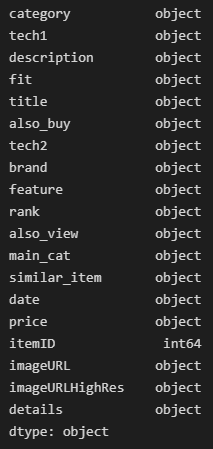




In [194]:
def plot_histogram(hist, title, xlabel, ylabel, save_name):
    mean_user = np.mean(hist)
    print("mean del histograma: {}".format(mean_user))
    x_minus_lim = min(hist)-2
    x_max_lim = max(hist)
    bins_array = range(min(hist),max(hist)+1)

    plt.hist(hist, bins=bins_array)
    #plt.xlim(min(hist),20)
    plt.xlim(x_minus_lim,x_max_lim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig("histogram.png")

In [195]:
# FUNCTIONS

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

def rows_to_delete(df, col, values):
    return df[df[col].isin(values)].index.values.tolist()

def delete_dulicated_rows(list_rows):
  return [*set(list_rows)]

def delete_rows_from_df(df, list_rows):
    return df.drop(list_rows)


# Eliminar usuarios con menos de 5 reviews


### Filas cuyos usuarios tienen menos de 5 reviews:

*rows_del_duplicated_th_reviewer*

### Lista con todas las rows que debemos eliminar

*rows_to_drop_csv*: Debe actualizarse 

In [196]:
raw_all_df.shape

(1512530, 12)

In [176]:
len(raw_all_df.reviewerID.unique())
len(raw_all_df.itemID.unique())

112222

In [177]:
"""
No tenemos en cuenta a usuarios que hayan hecho menos de  5 reviews
"""
th = 10
rows_to_drop_csv = []
histograma_reviewerID = raw_all_df.groupby(by="reviewerID")["itemID"].agg(['count'])
hist_reviewerID_below_th = histograma_reviewerID[histograma_reviewerID["count"] < th].index.values.tolist()
hist_reviewerID_above_th = histograma_reviewerID[histograma_reviewerID["count"] >= th].index.values.tolist()
rows_del_duplicated_th_reviewer = rows_to_delete(raw_all_df, "reviewerID", hist_reviewerID_below_th)

rows_to_drop_csv+=rows_del_duplicated_th_reviewer


In [178]:
"""
Info from the clean data
"""
rows_to_drop_csv = delete_dulicated_rows(rows_to_drop_csv)
data = raw_all_df
data_size = raw_all_df.shape[0]
data_without_rows = delete_rows_from_df(data, rows_to_drop_csv)
print("THEORY")
print("Total of users that are below the threshold {th}: {n_users_to_delete} out of {total_users}".format(th=th, n_users_to_delete=len(hist_reviewerID_below_th), total_users=len(histograma_reviewerID)))
print("Total of users (updated): {new_total_u}".format(new_total_u=len(histograma_reviewerID)-len(hist_reviewerID_below_th)))
print("\nHemos prescindido del {0:.2f}%, de los usuarios.".format(len(hist_reviewerID_below_th)/len(histograma_reviewerID)))
print("Interactions inside dataset:") 
print("\tInitial interactions: {init}".format(init=raw_all_df.shape[0] ))
print("\tDeleted interactions: {dele}".format(dele=raw_all_df.shape[0] - data_without_rows.shape[0]))
print("\tRemained interactions: {rem}".format(rem=data_without_rows.shape[0]))

THEORY
Total of users that are below the threshold 10: 893257 out of 903330
Total of users (updated): 10073

Hemos prescindido del 0.99%, de los usuarios.
Interactions inside dataset:
	Initial interactions: 1512530
	Deleted interactions: 1343547
	Remained interactions: 168983


In [172]:
"""
No tenemos en cuenta a usuarios que hayan hecho más de una review al mismo itemID
"""

df = raw_all_df[["reviewerID","itemID", "unixReviewTime"]].sort_values(by=["unixReviewTime"], ascending=False)
rows_del_duplicated_user_item = df[df.duplicated()].index.tolist()
rows_to_drop_csv+=rows_del_duplicated_user_item

rows_to_drop_csv = delete_dulicated_rows(rows_to_drop_csv)

print("Duplicados: ")
#print(raw_all_df[df.duplicated()])
print(len(df[df.duplicated()]))
print("Usuario 575627 se repite: ")
print(df[df.reviewerID ==575627])


Duplicados: 
39594
Usuario 575627 se repite: 
        reviewerID  itemID  unixReviewTime
312167      575627   18540      1041638400
348895      575627   18540      1041638400


In [168]:
raw_all_df

,overall,vote,verified,reviewTime,reviewerID,itemID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,90.0,False,"08 9, 2004",886861,5,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4.0,2.0,True,"04 6, 2017",302872,5,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,5.0,NaN,True,"03 14, 2017",868453,5,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,4.0,NaN,True,"02 14, 2017",153703,5,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,5.0,NaN,True,"01 29, 2017",782479,5,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1512525,5.0,NaN,True,"06 11, 2018",484007,112221,{'Color:': ' Black (2 Pack)'},Jeffrey,Hard to believe anyone will play their prized ...,Easy to install and does the job,1528675200,NaN
1512526,4.0,NaN,True,"06 7, 2018",887130,112221,{'Color:': ' Black (2 Pack)'},ryan,"Straplocks installed nicely, good fitment on m...",Worth.,1528329600,NaN
1512527,5.0,NaN,True,"06 3, 2018",182216,112221,{'Color:': ' Black (2 Pack)'},Cyclonus,Great Product,Great Product,1527984000,NaN
1512528,5.0,NaN,True,"05 29, 2018",205577,112221,{'Color:': ' Black (2 Pack)'},Zach Smith,I honestly expected these to be cheap pieces o...,A pleasant surprise,1527552000,NaN


In [167]:
df_csv_cleaned = delete_rows_from_df(raw_all_df,rows_to_drop_csv)
df_csv_cleaned

,overall,vote,verified,reviewTime,reviewerID,itemID,style,reviewerName,reviewText,summary,unixReviewTime,image
154,5.0,4.0,True,"04 17, 2013",561771,5,{'Format:': ' Paperback'},KCWANGSVICK,I have been crocheting for 50 years. When I bo...,Great reference book,1366156800,NaN
220,5.0,10.0,False,"08 3, 2006",318931,5,{'Format:': ' Paperback'},cinji,This is the best beginner book on the subject ...,Great Crochet Reference!,1154563200,NaN
243,5.0,NaN,True,"10 30, 2016",581175,16,NaN,francisco,It's good for beginners,Five Stars,1477785600,NaN
261,5.0,NaN,True,"06 30, 2016",678209,16,NaN,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN
275,4.0,26.0,False,"08 25, 2012",92584,15,NaN,jinx,I got this on sale for $49.99 and fro that muc...,good for a child,1345852800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1512508,3.0,NaN,True,"01 4, 2018",811134,112218,NaN,tonelab,Love the switches. Missing some metal washers...,May not contain all the hardware (metal washe...,1515024000,NaN
1512509,5.0,NaN,True,"12 31, 2017",898078,112218,NaN,Amazon Customer,Added PCB is useful and helps keep things orga...,Added PCB is useful and helps keep things orga...,1514678400,NaN
1512511,5.0,NaN,True,"08 6, 2016",583472,112218,NaN,Jeff,"Works like it should. Great little switches, ...",Works like it should,1470441600,NaN
1512523,4.0,NaN,True,"08 13, 2018",757259,112221,{'Color:': ' Gold (2 Pack)'},Ruben Estrada,They are not the Schaller locks but they wor...,Guitar strap locks . I recommend,1534118400,NaN


[1091,
 1110,
 1397,
 3920,
 4075,
 4614,
 4633,
 4702,
 4804,
 4837,
 4889,
 4910,
 4933,
 4972,
 4978,
 5027,
 5044,
 5046,
 5074,
 5164,
 5180,
 5202,
 5237,
 5350,
 5403,
 5429,
 5493,
 5593,
 5626,
 5691,
 6130,
 6271,
 6277,
 7801,
 7828,
 7884,
 7899,
 7923,
 7991,
 8113,
 8234,
 8322,
 8392,
 9156,
 9777,
 9784,
 9892,
 10020,
 10055,
 10093,
 10695,
 10719,
 10736,
 11015,
 11552,
 11553,
 11554,
 11555,
 11556,
 12133,
 12134,
 12135,
 12646,
 12647,
 12648,
 12649,
 12650,
 12651,
 12942,
 13306,
 13317,
 13322,
 13325,
 13349,
 13362,
 13403,
 13422,
 13469,
 13475,
 13565,
 14083,
 16188,
 16235,
 16959,
 17597,
 19192,
 19365,
 19983,
 20368,
 20423,
 20936,
 21024,
 21124,
 21132,
 21152,
 21376,
 21453,
 21562,
 21566,
 21586,
 22265,
 22292,
 22354,
 22381,
 22391,
 22404,
 22417,
 22517,
 22651,
 22669,
 22733,
 22840,
 22863,
 22974,
 23048,
 23079,
 23184,
 23533,
 23544,
 23628,
 24205,
 24248,
 24249,
 24335,
 24365,
 24429,
 24494,
 24706,
 24895,
 24968,
 26002,

In [ ]:
hist = histograma_reviewerID["count"]
title = "Número de interacción por usuario [not cleaned]"
xlabel = "Número de interacciones"
ylabel = "Cantidad de usuarios"
save_name = "histogramReviewerID_not_cleaned"
plot_histogram(hist, title, xlabel, ylabel, save_name)

In [ ]:
hist = hist_reviewerID_above_th
title = "Número de interacción por usuario [not cleaned]"
xlabel = "Número de interacciones"
ylabel = "Cantidad de usuarios"
save_name = "histogramReviewerID_not_cleaned"
plot_histogram(hist, title, xlabel, ylabel, save_name)

mean del histograma: 8.842204902515181


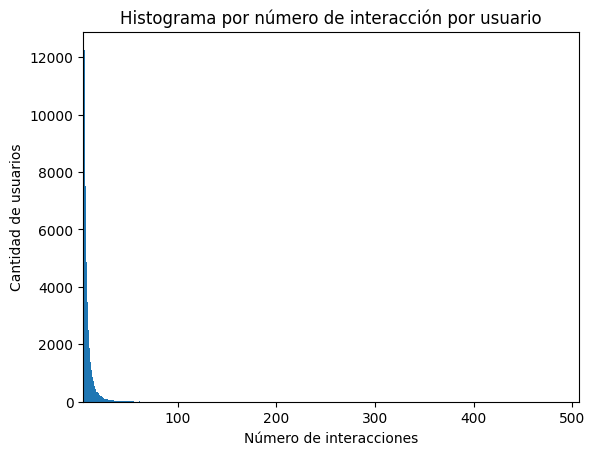

In [89]:
hist =  interact_freq[interact_freq >= th]
mean_user = np.mean(hist)
print("mean del histograma: {}".format(mean_user))
x_minus_lim = min(hist)-1
x_max_lim = max(hist)+1
bins_array = range(min(hist)-1,max(hist)+1)

plt.hist(hist, bins=bins_array)
#plt.xlim(min(hist),20)
plt.xlim(x_minus_lim,x_max_lim)
plt.xlabel("Número de interacciones")
plt.ylabel("Cantidad de usuarios")
plt.title("Histograma por número de interacción por usuario")
plt.savefig("histogram.png")

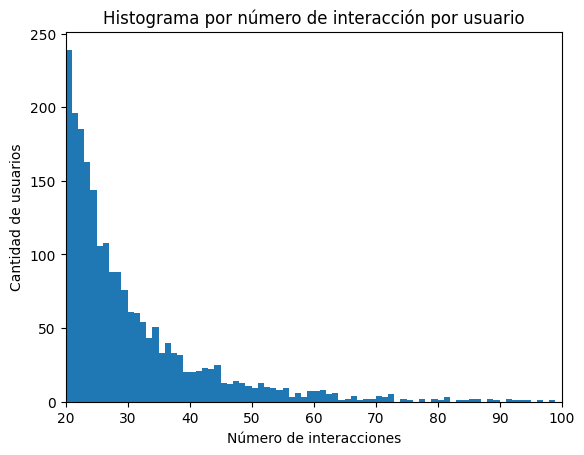

In [90]:
x_minus_lim = 20
x_max_lim = 100
bins_array = range(x_minus_lim,max(hist)+1)
plt.hist(hist, bins=bins_array)
#plt.xlim(min(hist),20)
plt.xlim(x_minus_lim,x_max_lim)
plt.xlabel("Número de interacciones")
plt.ylabel("Cantidad de usuarios")
plt.title("Histograma por número de interacción por usuario")
plt.savefig("histogram_zoom.png")

In [91]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

users_filtered_th = filter_rows_by_values(raw_all_df, "reviewerID", users_below_th)

In [98]:
raw_all_df.shape[0]-users_filtered_th.shape[0]

1152891

In [95]:
a = get_values_counts(users_filtered_th, "reviewerID")

Frequencia: 
397095    506
690587    275
538090    226
753703    193
806922    151
         ... 
380792      5
247283      5
129306      5
778090      5
609082      5
Name: reviewerID, Length: 40673, dtype: int64


In [56]:
raw_all_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'itemID',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

Frequencia: 
1456790400    2017
1453248000    1713
1482883200    1670
1483401600    1619
1420243200    1593
              ... 
1166745600       1
1144627200       1
1117843200       1
1125619200       1
1538611200       1
Name: unixReviewTime, Length: 5708, dtype: int64


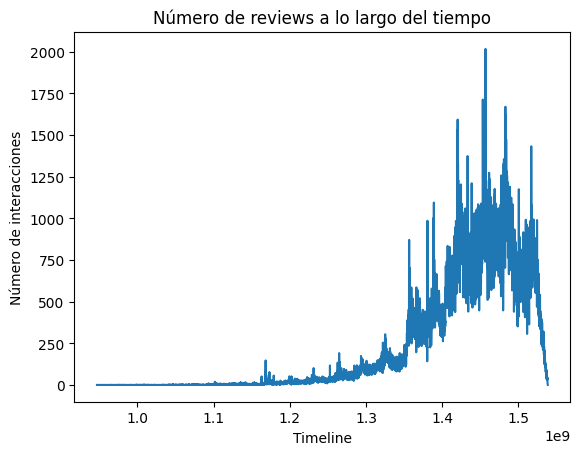

In [92]:
time_freq, inter_time_freq = get_values_counts(raw_all_df, "unixReviewTime")
inter_per_time = inter_time_freq[np.argsort(time_freq)]

plt.plot(np.sort(time_freq),inter_per_time)
plt.xlabel("Timeline")
plt.ylabel("Número de interacciones")
plt.title("Número de reviews a lo largo del tiempo")
plt.savefig("Timeline.png")

Frequencia: 
1456876800    432
1456790400    427
1453248000    390
1417392000    369
1480636800    352
             ... 
1215820800      1
1138752000      1
1201737600      1
1173830400      1
1537056000      1
Name: unixReviewTime, Length: 4477, dtype: int64


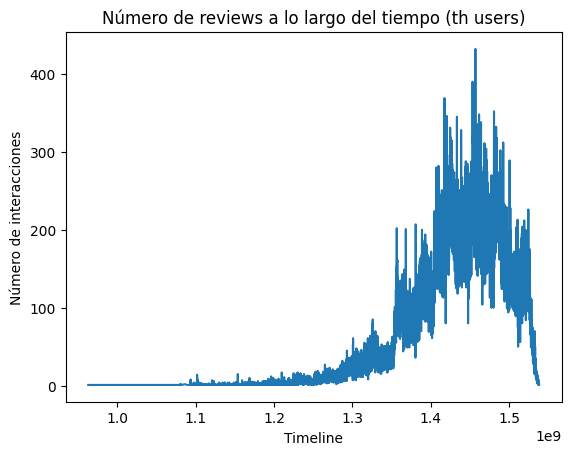

In [93]:
time_freq, inter_time_freq = get_values_counts(users_filtered_th, "unixReviewTime")
inter_per_time = inter_time_freq[np.argsort(time_freq)]

plt.plot(np.sort(time_freq),inter_per_time)
plt.xlabel("Timeline")
plt.ylabel("Número de interacciones")
plt.title("Número de reviews a lo largo del tiempo (th users)")
plt.savefig("Timeline_users_filtered.png")

In [109]:
raw_all_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'itemID',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

In [ ]:
th = 5
users = raw_all_df["reviewerID"]
usersID_freq, interact_freq = get_values_counts(raw_all_df, "reviewerID")
interact_below_th =  interact_freq[interact_freq < th]
users_below_th = usersID_freq[interact_freq < th] # Array of users below {th = 5} interactions
total_u = max(users)

In [122]:
histograma_reviewerID = raw_all_df.groupby(by="reviewerID")["itemID"].agg(['count'])
hist_reviewerID_below_th = histograma_reviewerID[histograma_reviewerID["count"] < th].index.values.tolist()
hist_reviewerID_above_th = histograma_reviewerID[histograma_reviewerID["count"] >= th].index.values.tolist()


In [115]:
a= raw_all_df[raw_all_df["reviewerID"] == 8]
a

,overall,vote,verified,reviewTime,reviewerID,itemID,style,reviewerName,reviewText,summary,unixReviewTime,image
575408,4.0,NaN,True,"08 2, 2016",8,46205,{'Color:': ' Black'},Art,dont know anything about guitar good bad or in...,dont know anything about guitar good bad or in...,1470096000,NaN
1011073,4.0,NaN,False,"08 2, 2016",8,104528,{'Length:': ' 10ft'},Art,it a cord it works,Four Stars,1470096000,NaN
1028359,4.0,NaN,False,"08 2, 2016",8,107140,NaN,Art,it a cord it works,Four Stars,1470096000,NaN


In [17]:
#raw_all_df["overall"].head()
raw_all_df.iloc[0] # row 0

overall                                                         5.0
vote                                                           90.0
verified                                                      False
reviewTime                                               08 9, 2004
reviewerID                                                   886861
itemID                                                            5
style                                     {'Format:': ' Paperback'}
reviewerName                                                  Bendy
reviewText        Crocheting for Dummies by Karen Manthey & Susa...
summary               Terrific Book for Learning the Art of Crochet
unixReviewTime                                           1092009600
image                                                           NaN
Name: 0, dtype: object